In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import datetime
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

## 读数据

In [2]:
path = 'process data/dataset4/'
df = pd.read_csv(path + 'dataset_4.csv')
df

,device_id,latitude,longitude,device_home_latitude,device_home_longitude
0,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659,22.327950,114.258985
1,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590,22.327950,114.258985
2,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441663,114.072847,22.441666,114.072836
3,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441631,114.072864,22.441666,114.072836
4,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441676,114.072764,22.441666,114.072836
...,...,...,...,...,...
4149496,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316356,114.174776,22.316361,114.174784
4149497,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316363,114.174783,22.316361,114.174784
4149498,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316363,114.174786,22.316361,114.174784
4149499,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316358,114.174779,22.316361,114.174784


## 读取香港building shape file

In [3]:
shapefile = gpd.read_file('Building_SHP/BUILDING_STRUCTURE.shp', encoding="GBK")
shapefile = shapefile.to_crs('EPSG:4326')
building_shp = shapefile[['OBJECTID', 'geometry']]
building_shp

,OBJECTID,geometry
0,1,"POLYGON ((113.84091 22.21870, 113.84090 22.218..."
1,2,"POLYGON ((113.84094 22.21863, 113.84095 22.218..."
2,3,"POLYGON ((113.84090 22.21867, 113.84091 22.218..."
3,4,"POLYGON ((113.84097 22.21871, 113.84101 22.218..."
4,5,"POLYGON ((113.84102 22.21870, 113.84101 22.218..."
...,...,...
340747,340748,"POLYGON ((114.43641 22.53999, 114.43638 22.539..."
340748,340749,"POLYGON ((114.43640 22.54116, 114.43640 22.541..."
340749,340750,"POLYGON ((114.43668 22.54119, 114.43659 22.541..."
340750,340751,"POLYGON ((114.43675 22.54050, 114.43670 22.540..."


In [4]:
## 定义一个 building_lat_lon_df ，存储 建筑物的 id 和 中心点经纬度
building_lat_lon_df = pd.DataFrame(columns=['OBJECTID', 'latitude', 'longitude'])

building_lat_lon_list = []

## 获取每个建筑物的中心点经纬度
for idx, row in building_shp.iterrows():
    if idx == 85188:
        print('已读取25%')
    elif idx == 170376:
        print('已读取50%')
    elif idx == 255564:
        print('已读取50%')
    elif idx == 340751:
        print('已读取100%')
    geometry = row['geometry']
    centroid = geometry.centroid
    lon = centroid.x
    lat = centroid.y
    
    # 存到字典
    building_lat_lon_data = {'OBJECTID': idx, 'latitude': lat, 'longitude': lon}
    
    # 将字典添加到列表
    building_lat_lon_list.append(building_lat_lon_data)

# 使用pd.concat()方法将列表转换为DataFrame
building_lat_lon_df = pd.concat([building_lat_lon_df, pd.DataFrame(building_lat_lon_list)])

building_lat_lon_df

已读取25%
已读取50%
已读取50%
已读取100%


,OBJECTID,latitude,longitude
0,0,22.218678,113.840891
1,1,22.218621,113.840924
2,2,22.218693,113.840934
3,3,22.218686,113.840983
4,4,22.218720,113.841003
...,...,...,...
340747,340747,22.539980,114.436365
340748,340748,22.541139,114.436364
340749,340749,22.541258,114.436660
340750,340750,22.540524,114.436728


In [6]:
building_lat_lon_df.dtypes

OBJECTID      object
latitude     float64
longitude    float64
dtype: object

## 住址经纬度df

In [5]:
home_lat_lon_df = df[['device_id','device_home_latitude','device_home_longitude']]
home_lat_lon_df = home_lat_lon_df.drop_duplicates()
home_lat_lon_df

,device_id,device_home_latitude,device_home_longitude
0,f46a65f1-db93-477b-a2e6-798f09b778a3,22.327950,114.258985
2,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441666,114.072836
10,f6fba5cc-51ae-4552-a25c-9b6a1704e898,22.370887,114.119189
12,f632f8f5-6034-427f-ae14-6112159943d4,22.317133,114.228477
14,f610bf1a-294d-47bf-80b1-5fa28d27f61a,22.288295,114.192757
...,...,...,...
4146579,f988932c-eb48-4026-8a87-accbfae89a1a,22.345608,114.107869
4146784,eb6654f6-2422-44d3-a3e0-17f2c9213ebe,22.285961,114.216152
4148146,f3f3ac57-6bf3-47de-876d-44f1c9270617,22.427323,114.244050
4149109,beb8ea11-6c51-4c52-a214-2cdacf612096,22.371624,114.138882


In [ ]:
## 保存数据：home_lat_lon
home_lat_lon_df.to_csv(path + "home_lat_lon.csv", index=False)

In [6]:
## 转换为 GeoDataFrame
geometry = gpd.points_from_xy(home_lat_lon_df['device_home_longitude'], home_lat_lon_df['device_home_latitude'])
home_lat_lon_gdf = gpd.GeoDataFrame(home_lat_lon_df, geometry=geometry)
home_lat_lon_gdf.crs = 'EPSG:4326'
home_lat_lon_gdf = home_lat_lon_gdf.drop(['device_home_longitude','device_home_latitude'], axis=1)
home_lat_lon_gdf

,device_id,geometry
0,f46a65f1-db93-477b-a2e6-798f09b778a3,POINT (114.25899 22.32795)
2,f6ec9f4b-8020-467c-be2c-df948aebe5dc,POINT (114.07284 22.44167)
10,f6fba5cc-51ae-4552-a25c-9b6a1704e898,POINT (114.11919 22.37089)
12,f632f8f5-6034-427f-ae14-6112159943d4,POINT (114.22848 22.31713)
14,f610bf1a-294d-47bf-80b1-5fa28d27f61a,POINT (114.19276 22.28829)
...,...,...
4146579,f988932c-eb48-4026-8a87-accbfae89a1a,POINT (114.10787 22.34561)
4146784,eb6654f6-2422-44d3-a3e0-17f2c9213ebe,POINT (114.21615 22.28596)
4148146,f3f3ac57-6bf3-47de-876d-44f1c9270617,POINT (114.24405 22.42732)
4149109,beb8ea11-6c51-4c52-a214-2cdacf612096,POINT (114.13888 22.37162)


In [7]:
## 映射到building
home_merged_gdf = gpd.sjoin(building_shp, home_lat_lon_gdf, how='inner', predicate='intersects')
home_merged_gdf = home_merged_gdf.drop('index_right', axis=1)
home_merged_gdf

,OBJECTID,geometry,device_id
310,311,"POLYGON ((113.85992 22.25518, 113.85987 22.255...",9d84fd00-873a-4473-9c17-42bbf0402455
483,484,"POLYGON ((113.86199 22.25448, 113.86187 22.254...",7da1b9a7-3908-475e-a766-638b5d760eb7
573,574,"POLYGON ((113.86239 22.25465, 113.86238 22.254...",4b625d9c-fc79-465f-8315-8f39cca15e0e
698,699,"POLYGON ((113.86287 22.24768, 113.86284 22.247...",8f47afdb-70aa-438b-a65b-c23e70f1a7be
930,931,"POLYGON ((113.86357 22.25342, 113.86362 22.253...",35759845-e7ba-4b0a-88cf-529959667133
...,...,...,...
338948,338949,"POLYGON ((114.31958 22.44845, 114.31961 22.448...",0efd6c0d-6f95-47b9-a4b6-f0724a970a8f
339357,339358,"POLYGON ((114.32680 22.43128, 114.32686 22.431...",908023fa-e3a1-4a58-8b4c-c8b358ce252a
339447,339448,"POLYGON ((114.32859 22.45994, 114.32859 22.460...",9c63161a-3895-4dc9-820d-2de8fbeae333
339848,339849,"POLYGON ((114.35282 22.34764, 114.35281 22.347...",b2a074a2-fd10-463b-adc3-14288ae32f9c


In [8]:
home_building_df = home_merged_gdf[['device_id','OBJECTID']]
home_building_df

,device_id,OBJECTID
310,9d84fd00-873a-4473-9c17-42bbf0402455,311
483,7da1b9a7-3908-475e-a766-638b5d760eb7,484
573,4b625d9c-fc79-465f-8315-8f39cca15e0e,574
698,8f47afdb-70aa-438b-a65b-c23e70f1a7be,699
930,35759845-e7ba-4b0a-88cf-529959667133,931
...,...,...
338948,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,338949
339357,908023fa-e3a1-4a58-8b4c-c8b358ce252a,339358
339447,9c63161a-3895-4dc9-820d-2de8fbeae333,339448
339848,b2a074a2-fd10-463b-adc3-14288ae32f9c,339849


In [ ]:
# ## 保存数据：home_building
# home_building_df.to_csv(path + "home_building.csv", index=False)

## 位置经纬度df

In [9]:
location_lat_lon_df = df[['device_id','latitude','longitude']]
location_lat_lon_df

,device_id,latitude,longitude
0,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659
1,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590
2,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441663,114.072847
3,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441631,114.072864
4,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441676,114.072764
...,...,...,...
4149496,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316356,114.174776
4149497,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316363,114.174783
4149498,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316363,114.174786
4149499,b56a2980-91b2-415d-945f-8a445d5bbe60,22.316358,114.174779


In [ ]:
## 保存数据：location_lat_lon
location_lat_lon_df.to_csv(path + "location_lat_lon.csv", index=False)

In [10]:
## 转换为 GeoDataFrame
geometry = gpd.points_from_xy(location_lat_lon_df['longitude'], location_lat_lon_df['latitude'])
location_lat_lon_gdf = gpd.GeoDataFrame(location_lat_lon_df, geometry=geometry)
location_lat_lon_gdf.crs = 'EPSG:4326'
location_lat_lon_gdf = location_lat_lon_gdf.drop(['longitude','latitude'], axis=1)
location_lat_lon_gdf

,device_id,geometry
0,f46a65f1-db93-477b-a2e6-798f09b778a3,POINT (114.25766 22.32650)
1,f46a65f1-db93-477b-a2e6-798f09b778a3,POINT (114.25759 22.32650)
2,f6ec9f4b-8020-467c-be2c-df948aebe5dc,POINT (114.07285 22.44166)
3,f6ec9f4b-8020-467c-be2c-df948aebe5dc,POINT (114.07286 22.44163)
4,f6ec9f4b-8020-467c-be2c-df948aebe5dc,POINT (114.07276 22.44168)
...,...,...
4149496,b56a2980-91b2-415d-945f-8a445d5bbe60,POINT (114.17478 22.31636)
4149497,b56a2980-91b2-415d-945f-8a445d5bbe60,POINT (114.17478 22.31636)
4149498,b56a2980-91b2-415d-945f-8a445d5bbe60,POINT (114.17479 22.31636)
4149499,b56a2980-91b2-415d-945f-8a445d5bbe60,POINT (114.17478 22.31636)


In [11]:
## 映射到building
location_merged_gdf = gpd.sjoin(building_shp, location_lat_lon_gdf, how='inner', predicate='intersects')
location_merged_gdf = location_merged_gdf.drop('index_right', axis=1)
location_merged_gdf

,OBJECTID,geometry,device_id
272,273,"POLYGON ((113.85853 22.25552, 113.85837 22.255...",8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4
272,273,"POLYGON ((113.85853 22.25552, 113.85837 22.255...",8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4
272,273,"POLYGON ((113.85853 22.25552, 113.85837 22.255...",8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4
272,273,"POLYGON ((113.85853 22.25552, 113.85837 22.255...",8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4
275,276,"POLYGON ((113.85858 22.25524, 113.85853 22.255...",b97b99f2-f624-48b6-9911-a069f801e74f
...,...,...,...
340457,340458,"POLYGON ((114.37067 22.39625, 114.37072 22.396...",97178f27-21db-4bc2-a3fc-ccef5ca52994
340457,340458,"POLYGON ((114.37067 22.39625, 114.37072 22.396...",97178f27-21db-4bc2-a3fc-ccef5ca52994
340457,340458,"POLYGON ((114.37067 22.39625, 114.37072 22.396...",97178f27-21db-4bc2-a3fc-ccef5ca52994
340457,340458,"POLYGON ((114.37067 22.39625, 114.37072 22.396...",97178f27-21db-4bc2-a3fc-ccef5ca52994


In [12]:
location_building_df = location_merged_gdf[['device_id','OBJECTID']]
location_building_df

,device_id,OBJECTID
272,8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4,273
272,8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4,273
272,8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4,273
272,8a185e38-bfb5-48cb-bcfe-7a3c4accf2c4,273
275,b97b99f2-f624-48b6-9911-a069f801e74f,276
...,...,...
340457,97178f27-21db-4bc2-a3fc-ccef5ca52994,340458
340457,97178f27-21db-4bc2-a3fc-ccef5ca52994,340458
340457,97178f27-21db-4bc2-a3fc-ccef5ca52994,340458
340457,97178f27-21db-4bc2-a3fc-ccef5ca52994,340458


In [ ]:
# ## 保存数据：location_building
# location_building_df.to_csv(path + "location_building.csv", index=False)

## 计算 location_building_df 中 每个device的 住址OBJECTID

In [13]:
## 计算每个 device_id 的每个 OBJECTID 出现的次数
counts = location_building_df.groupby(['device_id','OBJECTID']).size()
counts

device_id                             OBJECTID
00000f8e-3fca-60b8-10b1-d27413b0cf19  235523        4
                                      237767        1
0000b42b-03f1-6be9-bf91-df48dfebb628  175376       12
0001ca98-70ec-6e99-be41-e272d9639921  217482        5
                                      217797       16
                                                 ... 
fff894d6-9c6f-4bd2-92f3-77c135c96069  239951        8
fffa70b5-2607-44de-a708-57a945ef9099  276223        1
fffc5a1f-54c7-46f3-a748-4f05fde20c92  307335      100
                                      307386       23
fffd6e85-73be-4196-bd88-373dced6dcc9  316387        1
Length: 155462, dtype: int64

In [14]:
## 保存 device_id 和 这个OBJECTID出现次数最多的 OBJECTID
max_OBJECTID = counts.groupby('device_id').idxmax().apply(lambda x: x[1])
max_OBJECTID

device_id
00000f8e-3fca-60b8-10b1-d27413b0cf19    235523
0000b42b-03f1-6be9-bf91-df48dfebb628    175376
0001ca98-70ec-6e99-be41-e272d9639921    217797
0001f072-e4f8-400c-8463-a5669551630d     14326
00029b54-f2ca-4ba9-a2b8-c7802c23978a    248189
                                         ...  
fff6dbac-484b-4acc-90e7-7721b1750961    249448
fff894d6-9c6f-4bd2-92f3-77c135c96069    239951
fffa70b5-2607-44de-a708-57a945ef9099    276223
fffc5a1f-54c7-46f3-a748-4f05fde20c92    307335
fffd6e85-73be-4196-bd88-373dced6dcc9    316387
Length: 61855, dtype: int64

In [15]:
location_building_pred_df = pd.DataFrame({'device_id': max_OBJECTID.index, 'OBJECTID': max_OBJECTID.values})
location_building_pred_df

,device_id,OBJECTID
0,00000f8e-3fca-60b8-10b1-d27413b0cf19,235523
1,0000b42b-03f1-6be9-bf91-df48dfebb628,175376
2,0001ca98-70ec-6e99-be41-e272d9639921,217797
3,0001f072-e4f8-400c-8463-a5669551630d,14326
4,00029b54-f2ca-4ba9-a2b8-c7802c23978a,248189
...,...,...
61850,fff6dbac-484b-4acc-90e7-7721b1750961,249448
61851,fff894d6-9c6f-4bd2-92f3-77c135c96069,239951
61852,fffa70b5-2607-44de-a708-57a945ef9099,276223
61853,fffc5a1f-54c7-46f3-a748-4f05fde20c92,307335


## 验证

###### 先通过 device_id 关联 home_building_df 和 location_building_pred_df ，得到 device_id ，OBJECTID_home 和 OBJECTID_location ，然后分别与 building_lat_lon_df 的 OBJECTID 关联，得到 OBJECTID_home 和 OBJECTID_location 的经纬度，然后使用 geod.geometry_length(line_string) 计算 OBJECTID_home 和 OBJECTID_location 之间的距离。

In [16]:
home_building_df = home_building_df.rename(columns = {'OBJECTID': 'OBJECTID_home'})
home_building_df

,device_id,OBJECTID_home
310,9d84fd00-873a-4473-9c17-42bbf0402455,311
483,7da1b9a7-3908-475e-a766-638b5d760eb7,484
573,4b625d9c-fc79-465f-8315-8f39cca15e0e,574
698,8f47afdb-70aa-438b-a65b-c23e70f1a7be,699
930,35759845-e7ba-4b0a-88cf-529959667133,931
...,...,...
338948,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,338949
339357,908023fa-e3a1-4a58-8b4c-c8b358ce252a,339358
339447,9c63161a-3895-4dc9-820d-2de8fbeae333,339448
339848,b2a074a2-fd10-463b-adc3-14288ae32f9c,339849


In [17]:
location_building_pred_df = location_building_pred_df.rename(columns = {'OBJECTID': 'OBJECTID_location'})
location_building_pred_df

,device_id,OBJECTID_location
0,00000f8e-3fca-60b8-10b1-d27413b0cf19,235523
1,0000b42b-03f1-6be9-bf91-df48dfebb628,175376
2,0001ca98-70ec-6e99-be41-e272d9639921,217797
3,0001f072-e4f8-400c-8463-a5669551630d,14326
4,00029b54-f2ca-4ba9-a2b8-c7802c23978a,248189
...,...,...
61850,fff6dbac-484b-4acc-90e7-7721b1750961,249448
61851,fff894d6-9c6f-4bd2-92f3-77c135c96069,239951
61852,fffa70b5-2607-44de-a708-57a945ef9099,276223
61853,fffc5a1f-54c7-46f3-a748-4f05fde20c92,307335


In [18]:
## 关联 home_building_df 和 location_building_pred_df
merged_df = home_building_df.merge(location_building_pred_df, on='device_id', how='inner')
merged_df

,device_id,OBJECTID_home,OBJECTID_location
0,9d84fd00-873a-4473-9c17-42bbf0402455,311,311
1,7da1b9a7-3908-475e-a766-638b5d760eb7,484,481
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,574,593
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,699,699
4,35759845-e7ba-4b0a-88cf-529959667133,931,937
...,...,...,...
31333,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,338949,338949
31334,908023fa-e3a1-4a58-8b4c-c8b358ce252a,339358,339358
31335,9c63161a-3895-4dc9-820d-2de8fbeae333,339448,339448
31336,b2a074a2-fd10-463b-adc3-14288ae32f9c,339849,339849


In [19]:
## 关联 home 的 经纬度
merged_home_df = merged_df.merge(building_lat_lon_df, left_on='OBJECTID_home', right_on='OBJECTID')
merged_home_df = merged_home_df.drop(['OBJECTID_home','OBJECTID'], axis=1)
merged_home_df = merged_home_df.rename(columns = {'latitude': 'latitude_home', 'longitude': 'longitude_home'})
merged_home_df

,device_id,OBJECTID_location,latitude_home,longitude_home
0,9d84fd00-873a-4473-9c17-42bbf0402455,311,22.255307,113.860310
1,7da1b9a7-3908-475e-a766-638b5d760eb7,481,22.254409,113.861950
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,593,22.247495,113.862420
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,699,22.254562,113.862869
4,35759845-e7ba-4b0a-88cf-529959667133,937,22.253697,113.863634
...,...,...,...,...
31333,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,338949,22.397590,114.319549
31334,908023fa-e3a1-4a58-8b4c-c8b358ce252a,339358,22.430566,114.326844
31335,9c63161a-3895-4dc9-820d-2de8fbeae333,339448,22.460345,114.328617
31336,b2a074a2-fd10-463b-adc3-14288ae32f9c,339849,22.347857,114.352787


In [20]:
## 关联 location 的 经纬度
merged_lat_lon_df = merged_home_df.merge(building_lat_lon_df, left_on='OBJECTID_location', right_on='OBJECTID')
merged_lat_lon_df = merged_lat_lon_df.drop(['OBJECTID_location','OBJECTID'], axis=1)
merged_lat_lon_df = merged_lat_lon_df.rename(columns = {'latitude': 'latitude_location', 'longitude': 'longitude_location'})
merged_lat_lon_df

,device_id,latitude_home,longitude_home,latitude_location,longitude_location
0,9d84fd00-873a-4473-9c17-42bbf0402455,22.255307,113.860310,22.255307,113.860310
1,7da1b9a7-3908-475e-a766-638b5d760eb7,22.254409,113.861950,22.254244,113.861921
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,22.247495,113.862420,22.257067,113.862466
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,22.254562,113.862869,22.254562,113.862869
4,35759845-e7ba-4b0a-88cf-529959667133,22.253697,113.863634,22.253677,113.863668
...,...,...,...,...,...
31333,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,22.397590,114.319549,22.397590,114.319549
31334,908023fa-e3a1-4a58-8b4c-c8b358ce252a,22.430566,114.326844,22.430566,114.326844
31335,9c63161a-3895-4dc9-820d-2de8fbeae333,22.460345,114.328617,22.460345,114.328617
31336,b2a074a2-fd10-463b-adc3-14288ae32f9c,22.347857,114.352787,22.347857,114.352787


In [24]:
## 计算距离

# from pyproj import Geod
# from shapely.geometry import Point, LineString, Polygon
from geopy.distance import geodesic
distances = []

## 计算距离
for index, row in merged_lat_lon_df.iterrows():
    home_point = (row['latitude_home'], row['longitude_home'])
    location_point = (row['latitude_location'], row['longitude_location'])
#     line_string = LineString([home_point, location_point])
#     geod = Geod(ellps="WGS84")
#     distance = geod.geometry_length(line_string)
    distance = geodesic(home_point, location_point).meters
    distances.append(distance)

merged_lat_lon_df['distance'] = distances
merged_lat_lon_df

,device_id,latitude_home,longitude_home,latitude_location,longitude_location,distance
0,9d84fd00-873a-4473-9c17-42bbf0402455,22.255307,113.860310,22.255307,113.860310,0.000000
1,7da1b9a7-3908-475e-a766-638b5d760eb7,22.254409,113.861950,22.254244,113.861921,18.453414
2,4b625d9c-fc79-465f-8315-8f39cca15e0e,22.247495,113.862420,22.257067,113.862466,1059.944892
3,8f47afdb-70aa-438b-a65b-c23e70f1a7be,22.254562,113.862869,22.254562,113.862869,0.000000
4,35759845-e7ba-4b0a-88cf-529959667133,22.253697,113.863634,22.253677,113.863668,4.119394
...,...,...,...,...,...,...
31333,0efd6c0d-6f95-47b9-a4b6-f0724a970a8f,22.397590,114.319549,22.397590,114.319549,0.000000
31334,908023fa-e3a1-4a58-8b4c-c8b358ce252a,22.430566,114.326844,22.430566,114.326844,0.000000
31335,9c63161a-3895-4dc9-820d-2de8fbeae333,22.460345,114.328617,22.460345,114.328617,0.000000
31336,b2a074a2-fd10-463b-adc3-14288ae32f9c,22.347857,114.352787,22.347857,114.352787,0.000000


In [23]:
counts = merged_lat_lon_df['distance'].value_counts().sort_index() 
counts

0.000000        23189
0.026172            2
0.205618            1
0.278279            2
0.925550            1
                ...  
34524.653643        1
34982.147885        1
35673.276126        1
35680.931681        1
36168.274605        3
Name: distance, Length: 6247, dtype: int64

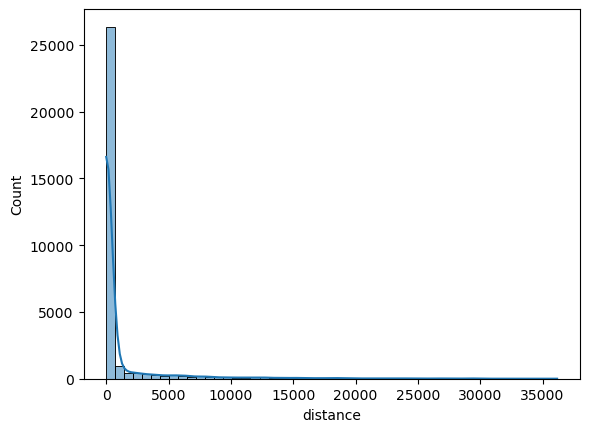

In [42]:
d = merged_lat_lon_df['distance']
sns.histplot(d,kde=True,bins=50)
plt.show()